# **Steel Defect Detection using Object Segmentation**

---

## **1. Business Objectives**

Steel is one of the most important building materials of modern times. Steel buildings are resistant to natural and man-made wear which has made the material ubiquitous around the world. 

Severstal is leading the charge in efficient steel mining and production. They believe the future of metallurgy requires development across the economic, ecological, and social aspects of the industry—and they take corporate responsibility seriously. The company recently created the country’s largest industrial data lake, with petabytes of data that were previously discarded. Severstal is now looking to machine learning to improve automation, increase efficiency, and maintain high quality in their production.

The production process of flat sheet steel is especially delicate. From heating and rolling, to drying and cutting, several machines touch flat steel by the time it’s ready to ship. 

In this project the objective is to predict the location and type of defects found in steel manufacturing. Given a image, the task is to classify the defect and locate the segmentation of the defect.


## **2. Data Collection**

The data was obtained from Kaggle. 

Link: https://www.kaggle.com/c/severstal-steel-defect-detection/data

The data file consists of:
  - DataTrain_images.Zip: Zip file containing all train images (12568 unique)
  - Test_images.zip: Zip file containing all test images (1801 unique)
  - train.csv: containing Imageid and Encoded Pixels columns
  - submission.csv: test csv file containing Imageid and Encoded Pixels columns

Each image is of size 1600 x 256 and may have no defects, a defect of a single class, or defects of multiple classes (ClassId = [1, 2, 3, 4]).

There are two tasks associated with this problem
  1. Classification of image into 4 defected classes (ClassId = [1, 2, 3, 4]).
  2. Predict the location of defects found (segmentation)


In [ ]:
# Connecting to Google drive

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Importing the necessary libraries

import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Setting up some parameters for the workbook

pd.set_option('display.max_rows', 500)
pd.options.display.max_columns = None

%matplotlib inline
mlp.rcParams["figure.figsize"] = (25, 5)
plt.style.use('seaborn')

In [ ]:
# Importing few helper libraries

import sys 
import os
import random
import shutil
import zipfile
from glob import glob
from datetime import datetime
from tqdm import tqdm_notebook

seed = 123
random.seed(seed)
np.random.seed(seed)

In [ ]:
!pip install keras==2.3.1
!pip install tensorflow==2.1.0
!pip install keras_applications==1.0.8
!pip install image-classifiers==1.0.0
!pip install segmentation-models
!pip install efficientnet==1.0.0
!pip install --upgrade git+https://github.com/qubvel/tta_wrapper/

     |████████████████████████████████| 378kB 14.1MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 421.8MB 31kB/s 
     |████████████████████████████████| 450kB 54.5MB/s 
     |████████████████████████████████| 3.9MB 53.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=7054c9a3efb204dd1261bac40db8938e139f11465c0701210b6e0b7ec983ef00
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.

In [ ]:
# Importing ML/DL Libraries

import cv2
from google.colab.patches import cv2_imshow

from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split

from tensorflow.python.keras import backend as K 

from tensorflow import keras
from keras import regularizers, optimizers, Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Input
from keras.layers import Conv1D, Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D, Dense, GlobalAveragePooling2D
from keras.optimizers import Adam

from keras.preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint

from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_v3 import InceptionV3

Using TensorFlow backend.


In [ ]:
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from tta_wrapper import tta_segmentation

Segmentation Models: using `keras` framework.


## **3. Data Preparation/Preprocessing**

We will start with loading and familiarizing with the dataset so that we can prepare the data for Machine Learning (ML) modelling.

In [ ]:
# Path for the folder containing dataset.

DRIVE_ZIP_DIR = "/content/drive/MyDrive/Colab Datasets/Steel Defect Detection"

In [ ]:
# Extracting the data

source_file_path = os.path.join(DRIVE_ZIP_DIR, "severstal-steel-defect-detection.zip")

print("Extracting contents of zip file.")
zip_ref = zipfile.ZipFile(source_file_path, 'r')
zip_ref.extractall(DRIVE_ZIP_DIR)
zip_ref.close()

print("Done..")

Extracting contents of zip file.
Done..


In [ ]:
# Loading the csv data file

file_path = os.path.join(DRIVE_ZIP_DIR, "train.csv")

raw_data = pd.read_csv(file_path)

### **3.1 Data Cleaning**

We will begin with data cleaning such that we can handle missing values, outliers, rare values and drop the unnecessary features that do not carry useful information.


In [ ]:
# Checking the features and no. of records in the dataset

print("The number of records are : ", raw_data.shape[0])
print("The number of features are : ", raw_data.shape[1])
print("The list of features is : ", raw_data.columns)
raw_data.head()

The number of records are :  7095
The number of features are :  3
The list of features is :  Index(['ImageId', 'ClassId', 'EncodedPixels'], dtype='object')


ImageId  ClassId                                      EncodedPixels
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0007a71bf.jpg        3  18661 28 18863 82 19091 110 19347 110 19603 11...
2  000a4bcdd.jpg        1  37607 3 37858 8 38108 14 38359 20 38610 25 388...
3  000f6bf48.jpg        4  131973 1 132228 4 132483 6 132738 8 132993 11 ...
4  0014fce06.jpg        3  229501 11 229741 33 229981 55 230221 77 230468...

Observations:
1. There are 7095 records of images and its ClassId and EncodedPixels.
2. The data uses run-length encoding on the pixel values. Instead of saving an exhaustive list of indices for the segmentation, it saves pairs of values that contain a start position and a run length. E.g. ‘1 3’ implies starting at pixel 1 and running a total of 3 pixels (1,2,3). 

    The format requires a space delimited list of pairs. For example, ‘1 3 10 5’ implies pixels 1,2,3,10,11,12,13,14 are to be included in the mask. 
    
    The metric checks that the pairs are sorted, positive, and the decoded pixel values are not duplicated. 
    
    The pixels are numbered from top to bottom, then left to right: 1 is pixel (1,1), 2 is pixel (2,1), etc.

3. It seems like that the details for undefected images have not been included in the csv file, so we need to add it to the dataframe.

In [ ]:
# Function to take MLE and convert it to image mask and return it in image resolution
def RLE_To_ImageMask(mask_rle, shape=(1600, 256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width, height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    # Splitting the run-length encoding
    s = mask_rle.split()
    # Creating a np array for start pixel and its length
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    # Reducing the start by 1
    starts -= 1
    # Creating a np array for end pixel
    ends = starts + lengths
    # Creating a img mask
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    # Entering 1 at the place for the defect pixels
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1

    return img.reshape(shape).T     


def Add_Undefected_Images(data): 
    """ 
        Takes the dataframe as input and return the updated datframe which contain both defected and undefected images information 
    """ 
    # Count the image file names for the given directory
    count = 0
    folder = os.path.join(DRIVE_ZIP_DIR, "train_images")
    filename_list = []
    for filename in os.listdir(folder):
        if filename not in data["ImageId"].values:
            filename_list.append(filename)
        count += 1
    # Print the total number of images present in the directory
    print("No. of Training images provided : ", count)
    print("No. of Undefected images : ", len(filename_list))
    
    # Creating the dictionary that contain the undefected images details
    dictionary = {}
    dictionary.update({"ImageId": filename_list, "ClassId": 0, "EncodedPixels": 0, "mask_pixel_sum": 0})
    data_undefected = pd.DataFrame(dictionary)

    # Concatinate the the defected and undefected images in the single dataframe called data.
    data = pd.concat([data, data_undefected])
    
    return data

In [ ]:
# Calculating the sum of defected pixels for the defected image
raw_data["mask_pixel_sum"] = raw_data.apply(lambda x: RLE_To_ImageMask(x["EncodedPixels"]).sum(), axis = 1)

# Adding details for the undefected images
raw_data = Add_Undefected_Images(raw_data)

No. of Training images provided :  12568
No. of Undefected images :  5902


In [ ]:
raw_data["binary_class"] = raw_data["ClassId"].apply(lambda x: 0 if x == 0 else 1)

In [ ]:
# Checking the features and no. of records in the dataset after including the details for missing images

print("The number of records are : ", raw_data.shape[0])
print("The number of features are : ", raw_data.shape[1])
print("The list of features is : ", raw_data.columns)

raw_data.head()

The number of records are :  12997
The number of features are :  5
The list of features is :  Index(['ImageId', 'ClassId', 'EncodedPixels', 'mask_pixel_sum',
       'binary_class'],
      dtype='object')


ImageId  ClassId                                      EncodedPixels  \
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...   
1  0007a71bf.jpg        3  18661 28 18863 82 19091 110 19347 110 19603 11...   
2  000a4bcdd.jpg        1  37607 3 37858 8 38108 14 38359 20 38610 25 388...   
3  000f6bf48.jpg        4  131973 1 132228 4 132483 6 132738 8 132993 11 ...   
4  0014fce06.jpg        3  229501 11 229741 33 229981 55 230221 77 230468...   

   mask_pixel_sum  binary_class  
0            4396             1  
1            6897             1  
2            8319             1  
3           69357             1  
4            4851             1

Observations:
1. It seems like there are few images with multiple class of defects as the number of records are greater than no. of training images provided.

In [ ]:
# Checking the no. of images with multiple class of defects

print("No. of images with multiple class of defects is : ", raw_data.shape[0] - 12568)

No. of images with multiple class of defects is :  429


In [ ]:
# Checking for duplicate records in the dataset

print("No. of duplicates records in the dataset : ", raw_data.duplicated().sum())

No. of duplicates records in the dataset :  0


In [ ]:
# Checking the basic info about the dataset

print("The basic info about the raw data is : \n")
raw_data.info()

The basic info about the raw data is : 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12997 entries, 0 to 5901
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ImageId         12997 non-null  object
 1   ClassId         12997 non-null  int64 
 2   EncodedPixels   12997 non-null  object
 3   mask_pixel_sum  12997 non-null  int64 
 4   binary_class    12997 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 929.2+ KB


#### **3.1.1 Handling Missing Values**

Identifying the features that have some missing values and imputing them.

In [ ]:
# Checking the missing values in the dataset

print("No. of missing values in the dataset : \n", raw_data.isnull().sum())

No. of missing values in the dataset : 
 ImageId           0
ClassId           0
EncodedPixels     0
mask_pixel_sum    0
binary_class      0
dtype: int64


### **3.2 Exploratory Data Analysis**

After the data cleaning steps, EDA will be performed on the dataset to discover patterns and relationships that will help in understanding the data better.

##### **1. Visualizing Defect vs No Defect Images**

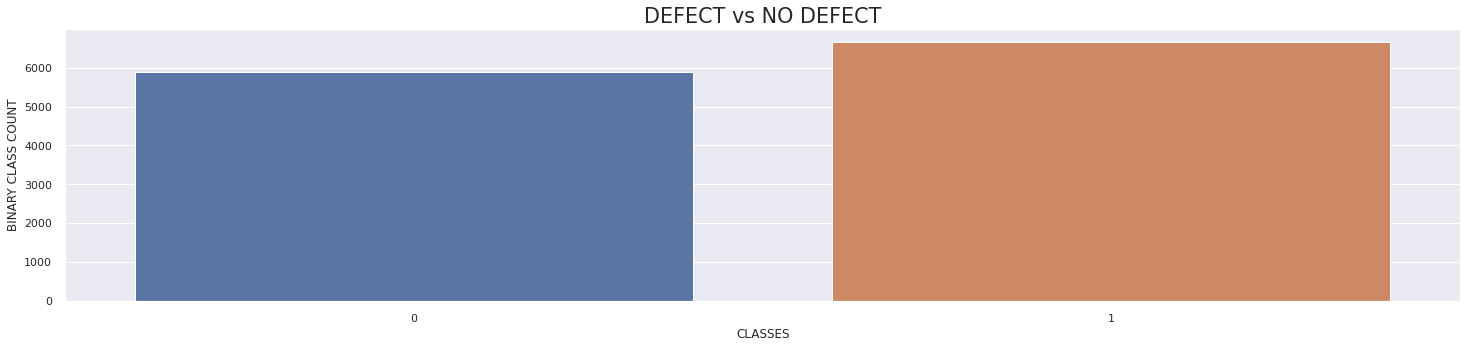

In [ ]:
# Plotting a countplot to visualize the distribution of reviews based on Rating Score

df_binary_clf = raw_data[["ImageId", "binary_class"]].drop_duplicates()

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5))

sns.countplot(x="binary_class", data=df_binary_clf, ax=axes)

plt.title("DEFECT vs NO DEFECT", fontsize='xx-large')
plt.xlabel("CLASSES")
plt.ylabel("BINARY CLASS COUNT")
plt.show() 

Observations:
1. There are around 5.8K+ unique images with no defects.
2. There are around 6K+ unique images with defects.

##### **2. Distibution of Defect Classes**

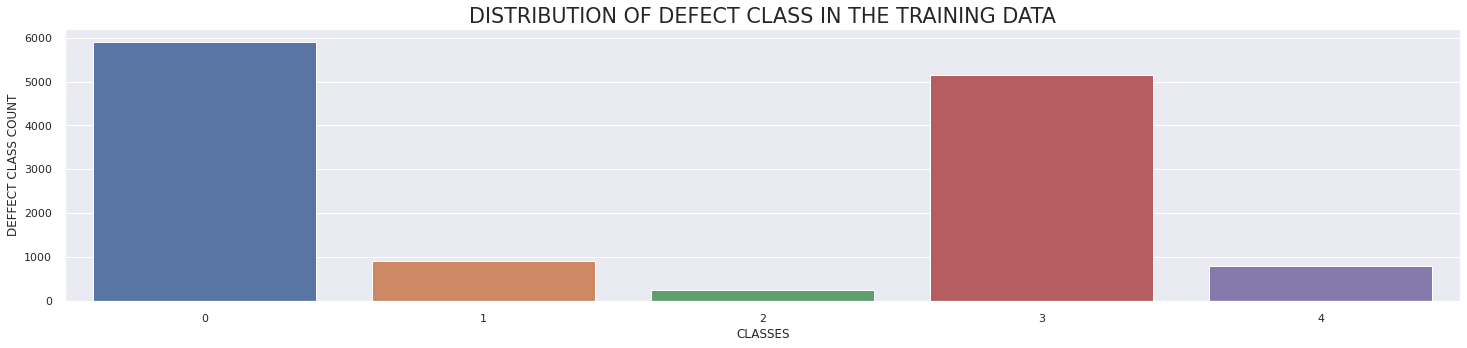

In [ ]:
# Plotting a countplot to visualize the distribution of reviews based on Rating Score

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5))

sns.countplot(x="ClassId", data=raw_data, ax=axes)

plt.title("DISTRIBUTION OF DEFECT CLASS IN THE TRAINING DATA", fontsize='xx-large')
plt.xlabel("CLASSES")
plt.ylabel("DEFFECT CLASS COUNT")
plt.show() 

Observations:
1. More than 5K+ records show no defects in the images.
2. Defect Class 3 is the highest among the 4 defect class with records of 5K+.
3. Defect class 1, 2 and 4 have records less than 1K. 

##### **3. Scatter Plot for Mask Pixel Sum**

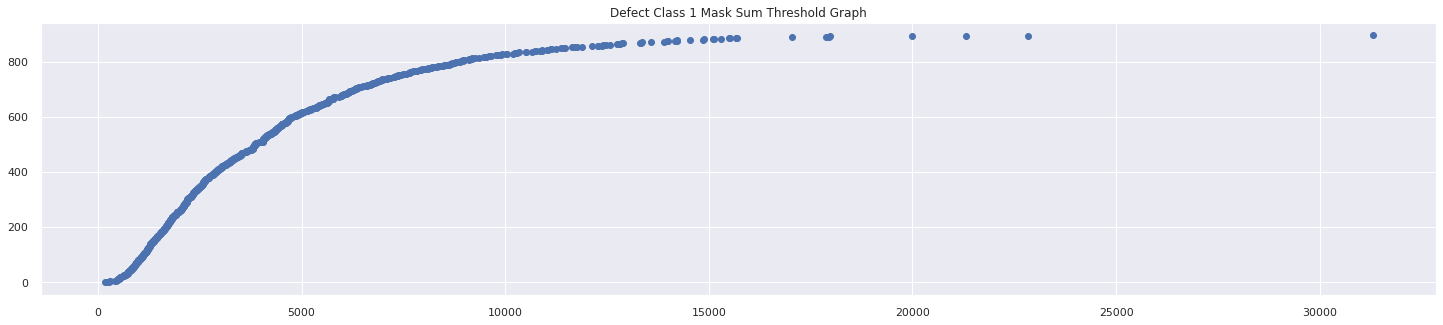

In [ ]:
# Checking the Mask Pixel Sum for all the images with Defect Class 1

a = [i for i in raw_data[raw_data["ClassId"] == 1]["mask_pixel_sum"].values]
a = sorted(a)

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5))

plt.title("Defect Class 1 Mask Sum Threshold Graph")
plt.scatter(a, range(len(a)))

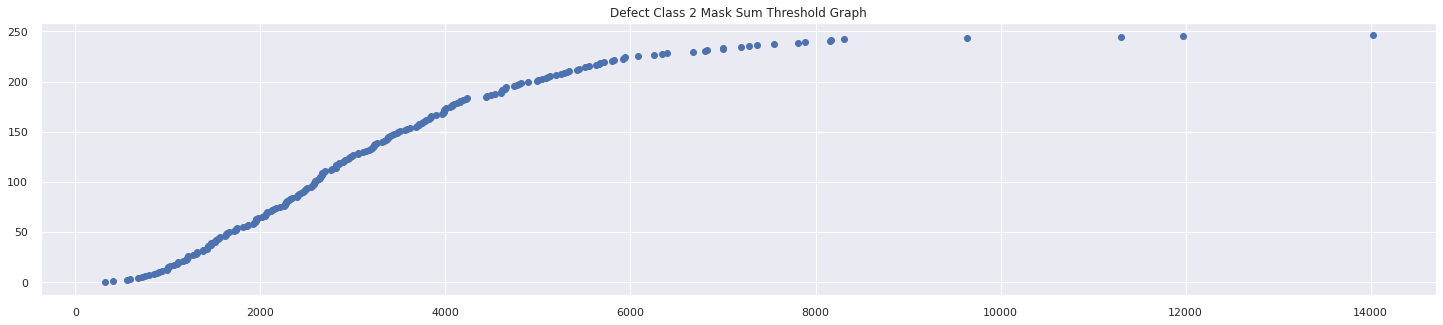

In [ ]:
# Checking the Mask Pixel Sum for all the images with Defect Class 2

a = [i for i in raw_data[raw_data["ClassId"] == 2]["mask_pixel_sum"].values]
a = sorted(a)

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5))

plt.title("Defect Class 2 Mask Sum Threshold Graph")
plt.scatter(a, range(len(a)))

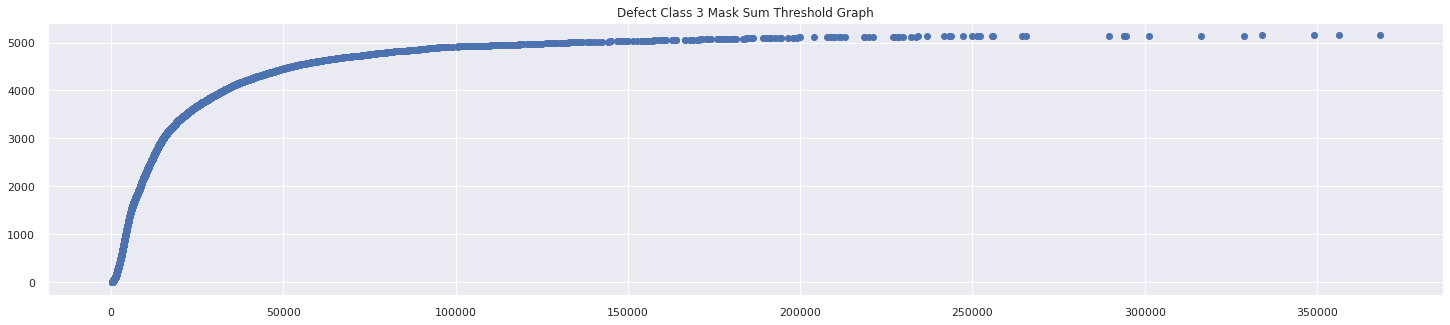

In [ ]:
# Checking the Mask Pixel Sum for all the images with Defect Class 3

a = [i for i in raw_data[raw_data["ClassId"] == 3]["mask_pixel_sum"].values]
a = sorted(a)

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5))

plt.title("Defect Class 3 Mask Sum Threshold Graph")
plt.scatter(a, range(len(a)))

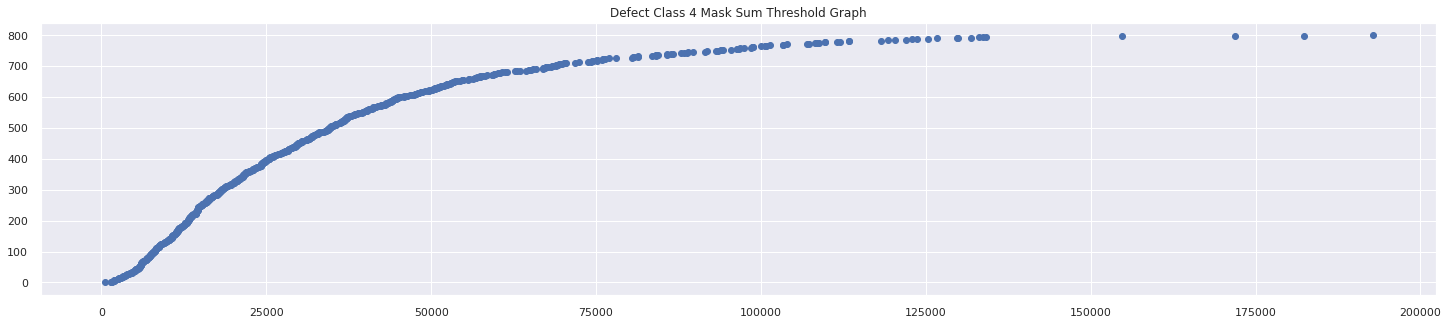

In [ ]:
# Checking the Mask Pixel Sum for all the images with Defect Class 4

a = [i for i in raw_data[raw_data["ClassId"] == 4]["mask_pixel_sum"].values]
a = sorted(a)

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5))

plt.title("Defect Class 4 Mask Sum Threshold Graph")
plt.scatter(a, range(len(a)))

##### **4. Viewing Images**

In [ ]:
def Show_Images(dataset, defect_type, start, end):
    """
        Showing the images of different defect type.
    """

    print(f"Defect Class {defect_type}")
    image_1 = dataset[dataset["ClassId"] == defect_type][start:end]["ImageId"].values
    for i in image_1:
        print("Image id : ", i)
        sns.set(style="darkgrid")
        plt.figure(figsize=(20, 4))
        # Loading the images one by one from the directory.
        image_read = cv2.imread(DRIVE_ZIP_DIR + "/train_images/" + i)
        image_read = cv2.cvtColor(image_read, cv2.COLOR_BGR2RGB)
        # Show the graph
        plt.imshow(image_read) 

Defect Class 0
Image id :  ebb8247c6.jpg
Image id :  ebd992f54.jpg
Image id :  ebde18416.jpg
Image id :  ebe4ba4f4.jpg


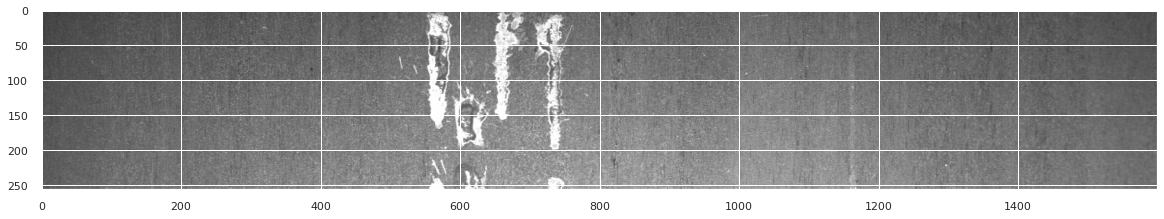

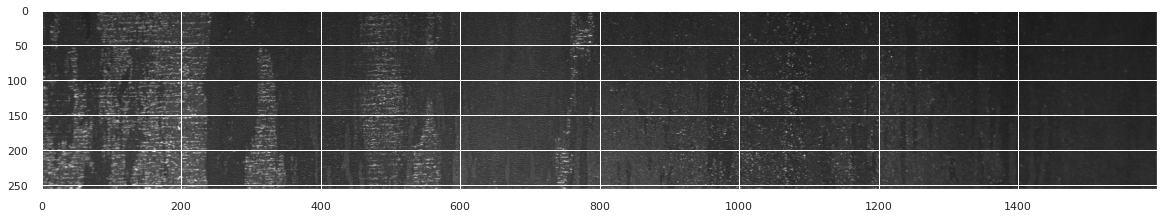

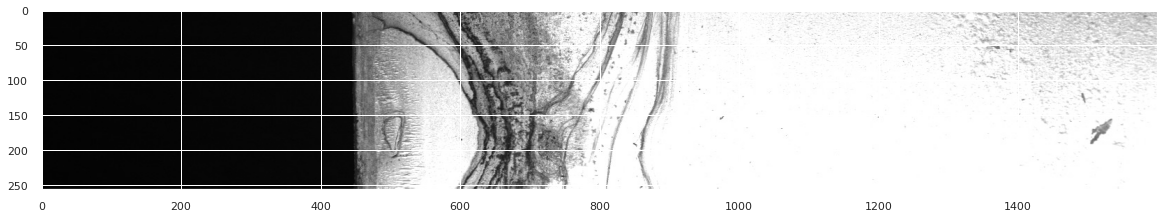

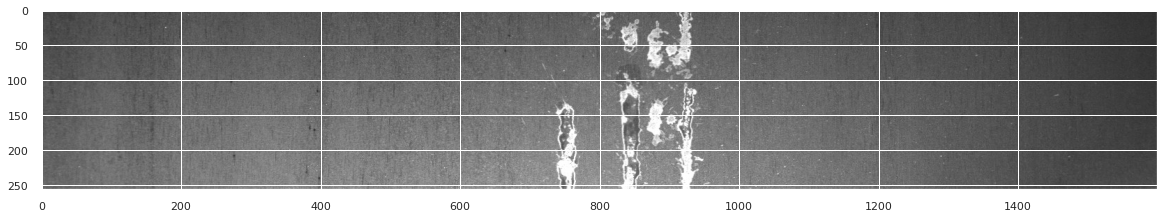

In [ ]:
# Showing 4 images from Defect Class 0

Show_Images(raw_data, 0, 20, 24)

Defect Class 1
Image id :  08f9c685f.jpg
Image id :  0905fe055.jpg
Image id :  0934b8bff.jpg
Image id :  0999e53af.jpg


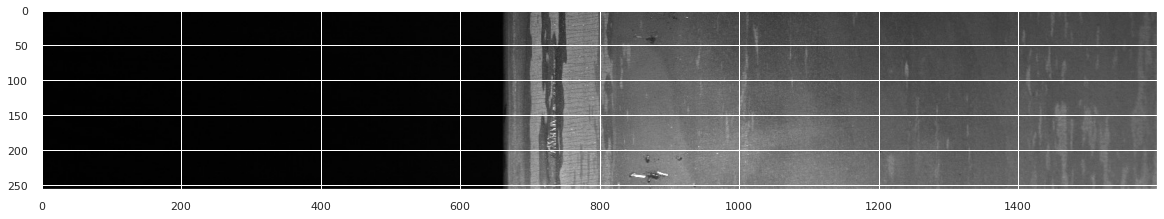

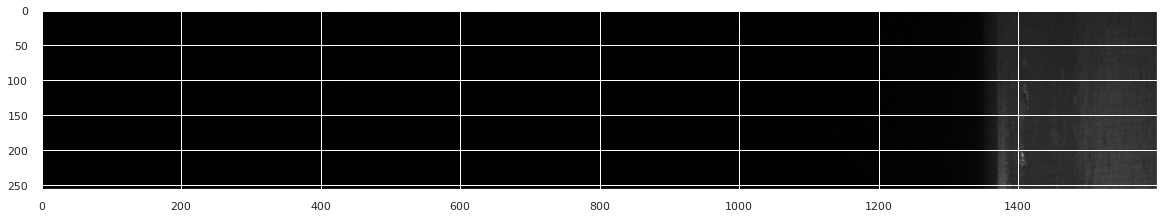

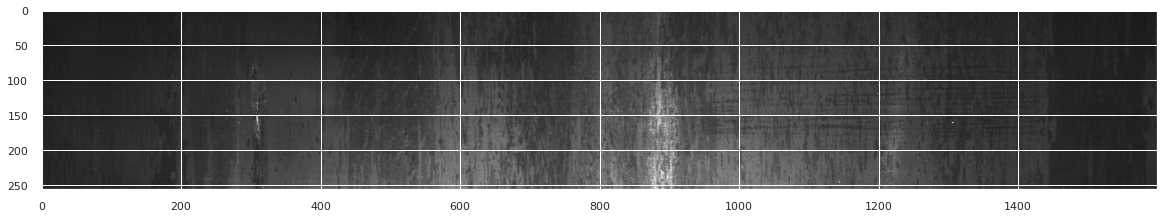

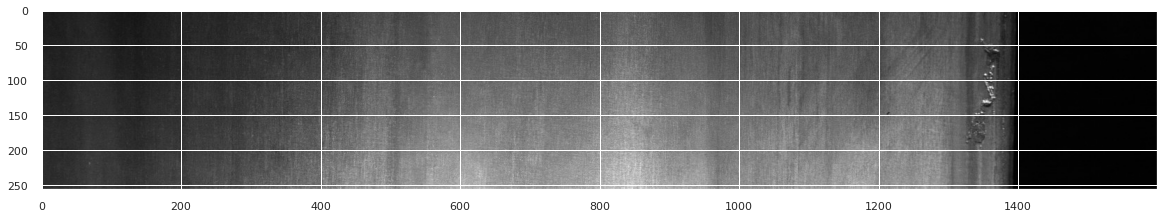

In [ ]:
# Showing 4 images from Defect Class 1

Show_Images(raw_data, 1, 35, 39)

Defect Class 2
Image id :  5ca7fcc19.jpg
Image id :  605ed0050.jpg
Image id :  6181b0a92.jpg
Image id :  62bf70fee.jpg


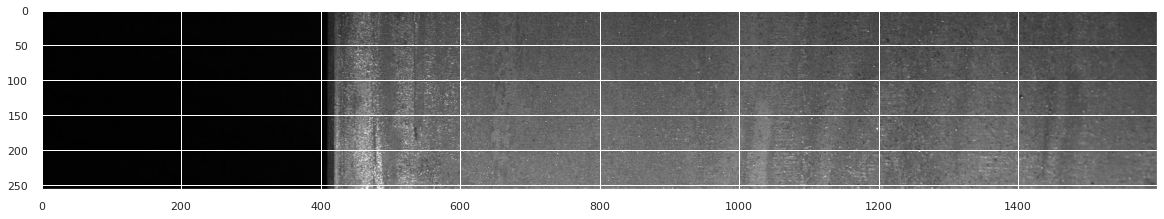

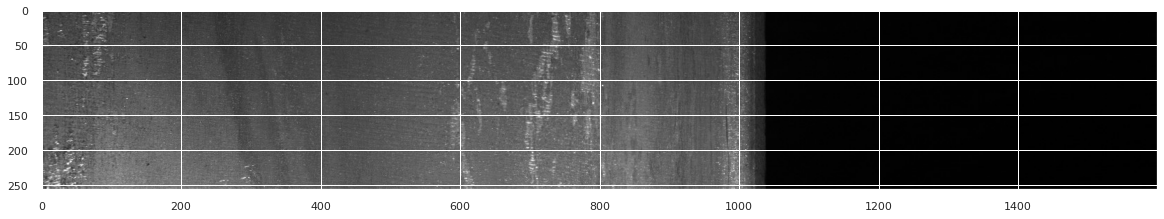

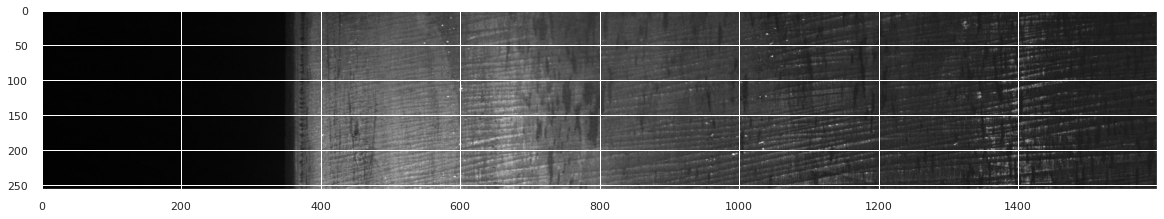

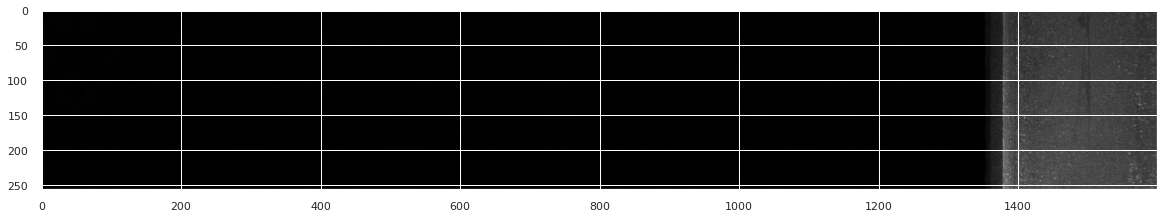

In [ ]:
# Showing 4 images from Defect Class 2

Show_Images(raw_data, 2, 89, 93)

Defect Class 3
Image id :  03860f6a9.jpg
Image id :  0386ce84b.jpg
Image id :  0391d44d6.jpg
Image id :  039577d49.jpg


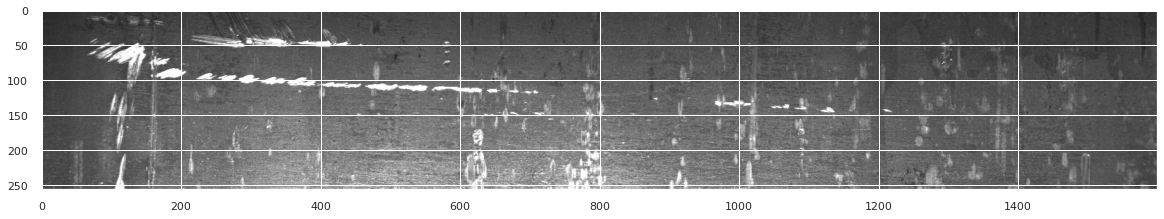

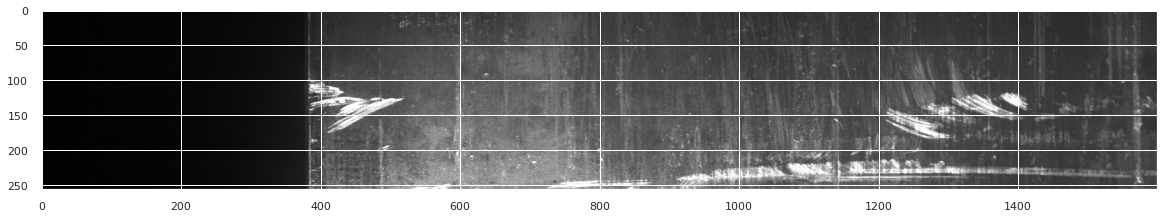

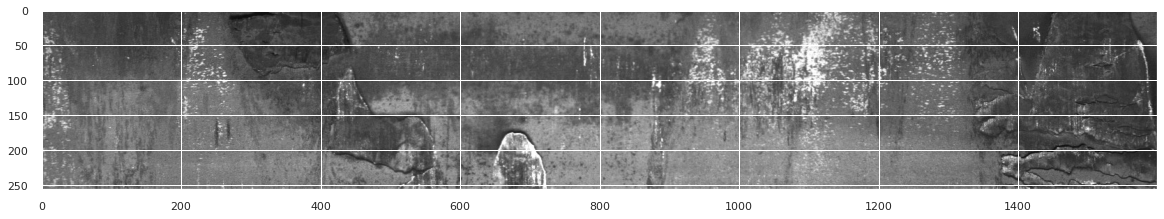

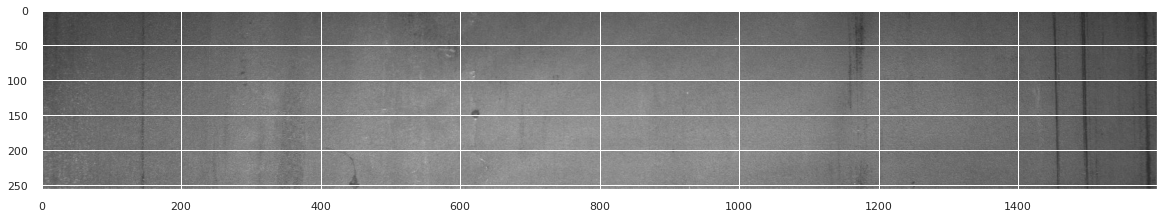

In [ ]:
# Showing 4 images from Defect Class 3

Show_Images(raw_data, 3, 65, 69)

Defect Class 4
Image id :  018ccdfed.jpg
Image id :  01afbfa7a.jpg
Image id :  01cfacf80.jpg
Image id :  0218c0fcc.jpg


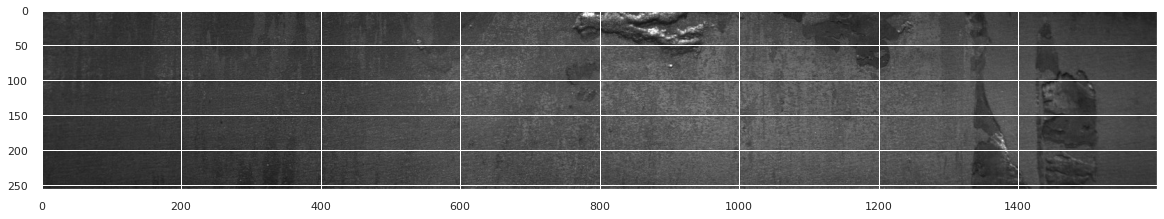

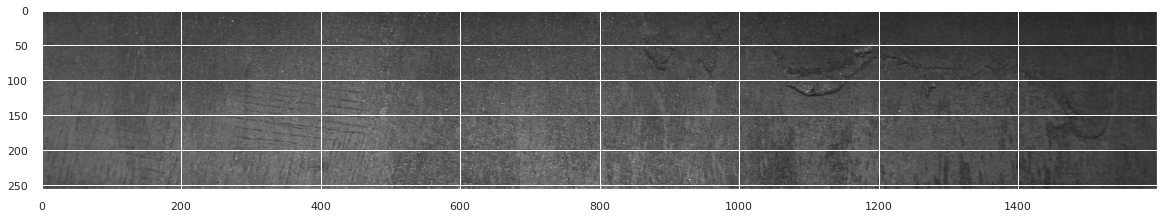

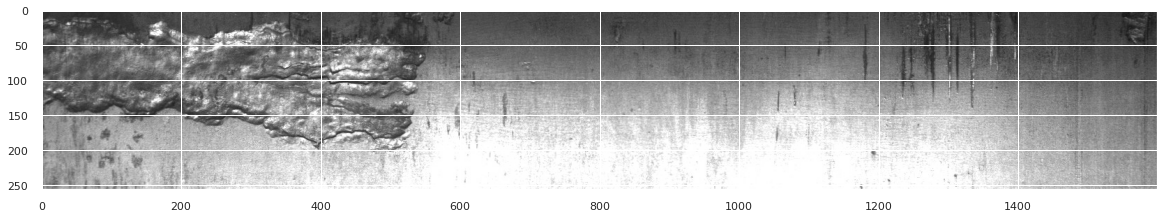

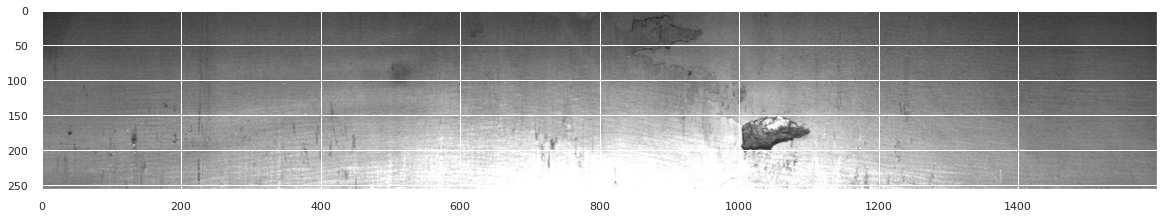

In [ ]:
# Showing 4 images from Defect Class 4

Show_Images(raw_data, 4, 7, 11)

##### **5. Viewing Mask**

Masked Image Defect Class 1


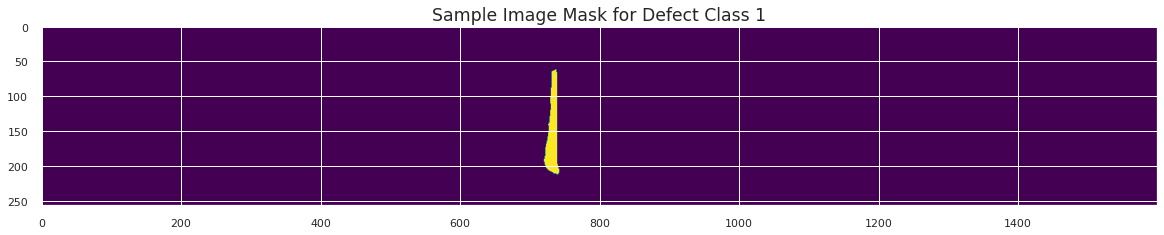

In [ ]:
# Viewing a sample masked image for defect class 1

Encoded = raw_data[raw_data["ClassId"] == 1]["EncodedPixels"].values[35]
print("Masked Image Defect Class 1")

Masked_image = RLE_To_ImageMask(Encoded)
plt.figure(figsize=(20, 4))
plt.title("Sample Image Mask for Defect Class 1", fontsize='x-large')
plt.imshow(Masked_image, cmap="viridis")

Masked Image Defect Class 2


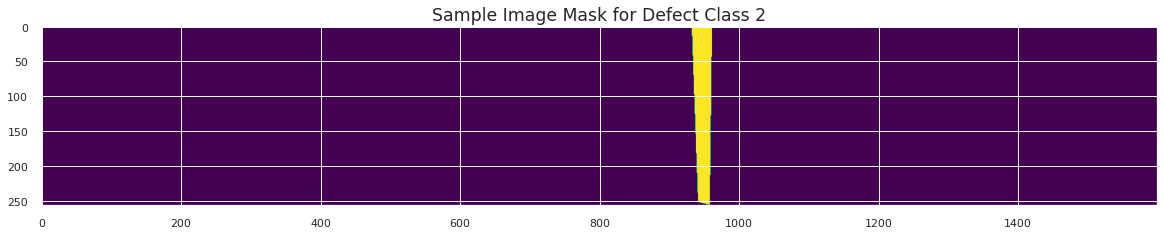

In [ ]:
# Viewing a sample masked image for defect class 2

Encoded = raw_data[raw_data["ClassId"] == 2]["EncodedPixels"].values[35]
print("Masked Image Defect Class 2")

Masked_image = RLE_To_ImageMask(Encoded)
plt.figure(figsize=(20, 4))
plt.title("Sample Image Mask for Defect Class 2", fontsize='x-large')
plt.imshow(Masked_image, cmap="viridis")

Masked Image Defect Class 3


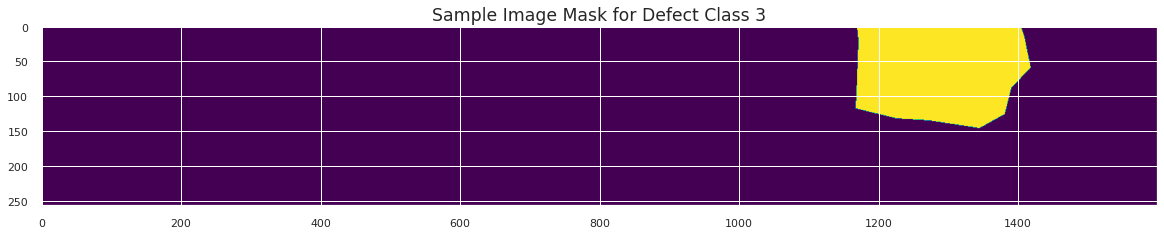

In [ ]:
# Viewing a sample masked image for defect class 3

Encoded = raw_data[raw_data["ClassId"] == 3]["EncodedPixels"].values[35]
print("Masked Image Defect Class 3")

Masked_image = RLE_To_ImageMask(Encoded)
plt.figure(figsize=(20, 4))
plt.title("Sample Image Mask for Defect Class 3", fontsize='x-large')
plt.imshow(Masked_image, cmap="viridis")

Masked Image Defect Class 4


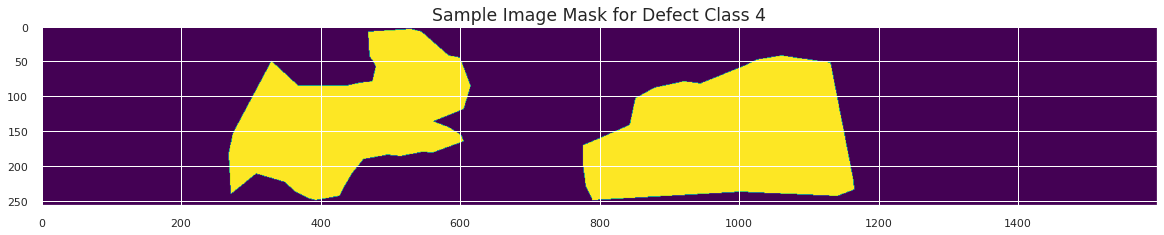

In [ ]:
# Viewing a sample masked image for defect class 4

Encoded = raw_data[raw_data["ClassId"] == 4]["EncodedPixels"].values[35]
print("Masked Image Defect Class 4")

Masked_image = RLE_To_ImageMask(Encoded)
plt.figure(figsize=(20, 4))
plt.title("Sample Image Mask for Defect Class 4", fontsize='x-large')
plt.imshow(Masked_image, cmap="viridis")

### **3.3 Feature Engineering**

Now that we have completed the data exploration part, we can start the Feature Engineering in order to prepare the data for the ML algorithms.

In [ ]:
# Creating a new feature by combining the image name and class

raw_data["ImageId_ClassId"] = raw_data["ImageId"] + "_" + raw_data["ClassId"].astype(str) 

In [ ]:
# Sorting the df based on image name and class

raw_data = raw_data.sort_values(by=["ImageId_ClassId"], axis=0, ignore_index=True)

In [ ]:
raw_data.head()

ImageId  ClassId                                      EncodedPixels  \
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...   
1  00031f466.jpg        0                                                  0   
2  000418bfc.jpg        0                                                  0   
3  000789191.jpg        0                                                  0   
4  0007a71bf.jpg        3  18661 28 18863 82 19091 110 19347 110 19603 11...   

   mask_pixel_sum  binary_class  ImageId_ClassId  
0            4396             1  0002cc93b.jpg_1  
1               0             0  00031f466.jpg_0  
2               0             0  000418bfc.jpg_0  
3               0             0  000789191.jpg_0  
4            6897             1  0007a71bf.jpg_3

In [ ]:
# Grouping the ImageId together to extract IDs with multiple defect classes
img_class_data = raw_data.groupby(["ImageId"])["ClassId"].agg(["unique"]).reset_index()

# Renaming the feature to "Class"
img_class_data.rename(columns = {"unique": "Class"}, inplace = True)

# Adding feature for each class
img_class_data["Class_0"] = 0
img_class_data["Class_1"] = 0
img_class_data["Class_2"] = 0
img_class_data["Class_3"] = 0
img_class_data["Class_4"] = 0

# Boolean feature indicating if defect exists
img_class_data["Any_Class"] = 0

img_class_data.head()

ImageId Class  Class_0  Class_1  Class_2  Class_3  Class_4  Any_Class
0  0002cc93b.jpg   [1]        0        0        0        0        0          0
1  00031f466.jpg   [0]        0        0        0        0        0          0
2  000418bfc.jpg   [0]        0        0        0        0        0          0
3  000789191.jpg   [0]        0        0        0        0        0          0
4  0007a71bf.jpg   [3]        0        0        0        0        0          0

In [ ]:
# Entering 1 in the respective Class feature and binary "Any_Class" feature

for idx, row in img_class_data.iterrows():
    if 0 in row.Class:
        img_class_data.at[idx, 'Class_0'] = 1
    if 1 in row.Class:
        img_class_data.at[idx, 'Class_1'] = 1
        img_class_data.at[idx, 'Any_Class'] = 1
    if 2 in row.Class:
        img_class_data.at[idx, 'Class_2'] = 1
        img_class_data.at[idx, 'Any_Class'] = 1
    if 3 in row.Class:
        img_class_data.at[idx, 'Class_3'] = 1
        img_class_data.at[idx, 'Any_Class'] = 1
    if 4 in row.Class:
        img_class_data.at[idx, 'Class_4'] = 1
        img_class_data.at[idx, 'Any_Class'] = 1

img_class_data["Sum_of_Defects"] = img_class_data["Class_1"] + img_class_data["Class_2"] + img_class_data["Class_3"] + img_class_data["Class_4"]
img_class_data.head()

ImageId Class  Class_0  Class_1  Class_2  Class_3  Class_4  \
0  0002cc93b.jpg   [1]        0        1        0        0        0   
1  00031f466.jpg   [0]        1        0        0        0        0   
2  000418bfc.jpg   [0]        1        0        0        0        0   
3  000789191.jpg   [0]        1        0        0        0        0   
4  0007a71bf.jpg   [3]        0        0        0        1        0   

   Any_Class  Sum_of_Defects  
0          1               1  
1          0               0  
2          0               0  
3          0               0  
4          1               1

In [ ]:
# Checking some basic informations regarding classes

print("The no. of unique Images is : ", len(img_class_data))

print("The no. of Images with defects is : ", len(img_class_data[img_class_data["Any_Class"] == 1]))
print("The no. of Images with no defects is : ", len(img_class_data[img_class_data["Any_Class"] == 0]))

print("The no. of Images with Class Defect 1 is : ", len(img_class_data[(img_class_data["Class_1"] == 1) & (img_class_data["Sum_of_Defects"] == 1)]))
print("The no. of Images with Class Defect 2 is : ", len(img_class_data[(img_class_data["Class_2"] == 1) & (img_class_data["Sum_of_Defects"] == 1)]))
print("The no. of Images with Class Defect 3 is : ", len(img_class_data[(img_class_data["Class_3"] == 1) & (img_class_data["Sum_of_Defects"] == 1)]))
print("The no. of Images with Class Defect 4 is : ", len(img_class_data[(img_class_data["Class_4"] == 1) & (img_class_data["Sum_of_Defects"] == 1)]))

print("The no. of Images with 1 Class Defects is : ", len(img_class_data[img_class_data["Sum_of_Defects"] == 1]))
print("The no. of Images with 2 Class Defects is : ", len(img_class_data[img_class_data["Sum_of_Defects"] == 2]))
print("The no. of Images with 3 Class Defects is : ", len(img_class_data[img_class_data["Sum_of_Defects"] == 3]))
print("The no. of Images with 4 Class Defects is : ", len(img_class_data[img_class_data["Sum_of_Defects"] == 4]))

The no. of unique Images is :  12568
The no. of Images with defects is :  6666
The no. of Images with no defects is :  5902
The no. of Images with Class Defect 1 is :  769
The no. of Images with Class Defect 2 is :  195
The no. of Images with Class Defect 3 is :  4759
The no. of Images with Class Defect 4 is :  516
The no. of Images with 1 Class Defects is :  6239
The no. of Images with 2 Class Defects is :  425
The no. of Images with 3 Class Defects is :  2
The no. of Images with 4 Class Defects is :  0


## **4. Model Building**

Creating Models for steel defect detection.

### **4.1 Training the Binary-Class CNN**

Training a customized CNN using InceptionResnetV2 pre-trained model and building a Binary-class (Class - Defect and No Defect) classifier.

In [ ]:
# Function to calculate to Recall
def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

# Function to calculate to Precision
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [ ]:
# Creating ImageDataGenerator for the dataset

columns = ["ImageId", "Class_1", "Class_2", "Class_3", "Class_4", "Any_Class", "Sum_of_Defects"]
y_columns = ["Any_Class"]
defect_df = img_class_data[columns]

mtr_df, mval_df = train_test_split(defect_df, stratify=defect_df[["Any_Class"]], test_size=0.20, random_state=42)

print("Train Data Shape :", mtr_df.shape, "Val Data Shape :", mval_df.shape)

train_datagen = ImageDataGenerator(rescale=1.0/255, shear_range=0.1, zoom_range=0.1, brightness_range=[0.6, 1.0], rotation_range=60, horizontal_flip=True, vertical_flip=True)
val_datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = train_datagen.flow_from_dataframe(dataframe= mtr_df, directory= DRIVE_ZIP_DIR + "/train_images", x_col="ImageId", y_col=y_columns, 
                                        batch_size=128, seed=42, shuffle=True, class_mode="other", target_size=(299, 299))

val_gen = val_datagen.flow_from_dataframe(dataframe= mval_df, directory= DRIVE_ZIP_DIR + "/train_images", x_col="ImageId", y_col=y_columns,
                                      batch_size=32, seed=42, shuffle=True, class_mode="other", target_size=(299, 299))

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = val_gen.n // val_gen.batch_size

Train Data Shape : (10054, 7) Val Data Shape : (2514, 7)
Found 10054 validated image filenames.
Found 2514 validated image filenames.


In [ ]:
# Using InceptionResNetV2 pre-trained model as base and adding multi-classification layers

model_mc = InceptionResNetV2(weights='imagenet', input_shape=(299, 299, 3), include_top= False)
model_mc.trainable=False

x = model_mc.output
x = GlobalAveragePooling2D()(x)
x=Dense(128, activation='relu')(x)
x=Dense(32, activation='relu')(x) 
out = Dense(1, activation='sigmoid')(x) 

model_binary_clf = Model(inputs = model_mc.input, outputs=out) 

219062272/219055592 [==============================] - 1s 0us/step


In [ ]:
# Compiling the model

opt = Adam(learning_rate=0.00001)
model_binary_clf.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model_binary_clf.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# Training our model

check_path = DRIVE_ZIP_DIR + "/model_binary_clf-improvement-{epoch:02d}-{val_accuracy:.2f}.h5"

checkpoint = ModelCheckpoint(check_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

startTime = datetime.now()
print("Starting Training..")

history_mc = model_binary_clf.fit(
                                  train_gen,
                                  steps_per_epoch=STEP_SIZE_TRAIN,
                                  validation_data=val_gen,
                                  validation_steps=STEP_SIZE_VALID,
                                  callbacks = callbacks_list,
                                  epochs=30,
                                  initial_epoch = 0
                                )

print("The training is complete after taking time of ", (datetime.now() - startTime))

Starting Training..
Epoch 1/30
78/78 [==============================] - 4192s 54s/step - loss: 0.6955 - accuracy: 0.5303 - val_loss: 0.6603 - val_accuracy: 0.6394

Epoch 00001: val_accuracy improved from -inf to 0.63942, saving model to /content/drive/MyDrive/Colab Datasets/Steel Defect Detection/model_binary_clf-improvement-01-0.64.h5
Epoch 2/30
78/78 [==============================] - 330s 4s/step - loss: 0.6426 - accuracy: 0.6682 - val_loss: 0.6405 - val_accuracy: 0.6599

Epoch 00002: val_accuracy improved from 0.63942 to 0.65986, saving model to /content/drive/MyDrive/Colab Datasets/Steel Defect Detection/model_binary_clf-improvement-02-0.66.h5
Epoch 3/30
78/78 [==============================] - 331s 4s/step - loss: 0.6105 - accuracy: 0.6987 - val_loss: 0.6259 - val_accuracy: 0.6807

Epoch 00003: val_accuracy improved from 0.65986 to 0.68069, saving model to /content/drive/MyDrive/Colab Datasets/Steel Defect Detection/model_binary_clf-improvement-03-0.68.h5
Epoch 4/30
78/78 [======

In [ ]:
# Continuing the training for more epochs

startTime = datetime.now()
print("Continuing training..")

history_mc = model_binary_clf.fit(
                                  train_gen,
                                  steps_per_epoch=STEP_SIZE_TRAIN,
                                  validation_data=val_gen,
                                  validation_steps=STEP_SIZE_VALID,
                                  callbacks = callbacks_list,
                                  epochs=50,
                                  initial_epoch = 30
                                 
                                )

print("The training is complete after taking time of ", (datetime.now() - startTime))

Continuing training..
Epoch 31/50
78/78 [==============================] - 328s 4s/step - loss: 0.3824 - accuracy: 0.8338 - val_loss: 0.4610 - val_accuracy: 0.7720

Epoch 00031: val_accuracy did not improve from 0.78446
Epoch 32/50
78/78 [==============================] - 328s 4s/step - loss: 0.3815 - accuracy: 0.8338 - val_loss: 0.4560 - val_accuracy: 0.7780

Epoch 00032: val_accuracy did not improve from 0.78446
Epoch 33/50
78/78 [==============================] - 327s 4s/step - loss: 0.3766 - accuracy: 0.8379 - val_loss: 0.4561 - val_accuracy: 0.7752

Epoch 00033: val_accuracy did not improve from 0.78446
Epoch 34/50
78/78 [==============================] - 328s 4s/step - loss: 0.3823 - accuracy: 0.8327 - val_loss: 0.4517 - val_accuracy: 0.7788

Epoch 00034: val_accuracy did not improve from 0.78446
Epoch 35/50
78/78 [==============================] - 327s 4s/step - loss: 0.3731 - accuracy: 0.8393 - val_loss: 0.4500 - val_accuracy: 0.7857

Epoch 00035: val_accuracy improved from 0.7

In [ ]:
# Saving the model

model_binary_clf.save(DRIVE_ZIP_DIR + '/model_binary_clf.h5')

In [ ]:
# Loading the model

model_path = DRIVE_ZIP_DIR + "/model_binary_clf.h5"

model_binary_clf = load_model(model_path)

### **4.2 Training the Multi-Class CNN**

Training a cutomized CNN using InceptionResnetV2 pre-trained model and building a multi-class (ClassID - 1, 2, 3, 4) classifier.

In [ ]:
# Creating ImageDataGenerator for the dataset

columns = ["ImageId", "Class_1", "Class_2", "Class_3", "Class_4", "Any_Class", "Sum_of_Defects"]
y_columns = ["Class_1", "Class_2", "Class_3", "Class_4"]
defect_df = img_class_data[img_class_data["Any_Class"] == 1][columns]

mtr_df, mval_df = train_test_split(defect_df, stratify=defect_df[["Sum_of_Defects"]], test_size=0.225, random_state=42)

print("Train Data Shape :", mtr_df.shape, "Val Data Shape :", mval_df.shape)

datagen=ImageDataGenerator(rescale=1.0/255, shear_range=0.1, zoom_range=0.1, brightness_range=[0.6, 1.0], rotation_range=60, horizontal_flip=True, vertical_flip=True)

train_gen = datagen.flow_from_dataframe(dataframe= mtr_df, directory= DRIVE_ZIP_DIR + "/train_images", x_col="ImageId", y_col=y_columns, 
                                        batch_size=128, seed=42, shuffle=True, class_mode="other", target_size=(299, 299))

val_gen = datagen.flow_from_dataframe(dataframe= mval_df, directory= DRIVE_ZIP_DIR + "/train_images", x_col="ImageId", y_col=y_columns,
                                      batch_size=32, seed=42, shuffle=True, class_mode="other", target_size=(299, 299))

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = val_gen.n // val_gen.batch_size

Train Data Shape : (5166, 7) Val Data Shape : (1500, 7)
Found 5166 validated image filenames.
Found 1500 validated image filenames.


In [ ]:
# Using InceptionResNetV2 pre-trained model as base and adding multi-classification layers

model_mc = InceptionResNetV2(weights='imagenet', input_shape=(299, 299, 3), include_top= False)
model_mc.trainable=False

x = model_mc.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
out = Dense(4, activation='softmax')(x) 

model_multi_clf = Model(inputs=model_mc.input, outputs=out) 

219062272/219055592 [==============================] - 2s 0us/step


In [ ]:
# Compiling the model

opt = Adam(learning_rate=0.00001)
model_multi_clf.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model_multi_clf.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# Training the multi-classification model

startTime = datetime.now()
print("Training started..")

history_mc = model_multi_clf.fit(
                                  train_gen,
                                  steps_per_epoch=STEP_SIZE_TRAIN,
                                  validation_data=val_gen,
                                  validation_steps=STEP_SIZE_VALID,
                                  epochs=50
                                )

print("The training is complete after taking time of ", (datetime.now() - startTime))

Training started..
Epoch 1/50
40/40 [==============================] - 1842s 46s/step - loss: 1.1850 - accuracy: 0.6486 - val_loss: 0.9407 - val_accuracy: 0.7609
Epoch 2/50
40/40 [==============================] - 198s 5s/step - loss: 0.8954 - accuracy: 0.7655 - val_loss: 0.8889 - val_accuracy: 0.7595
Epoch 3/50
40/40 [==============================] - 198s 5s/step - loss: 0.8777 - accuracy: 0.7549 - val_loss: 0.8558 - val_accuracy: 0.7609
Epoch 4/50
40/40 [==============================] - 198s 5s/step - loss: 0.8320 - accuracy: 0.7602 - val_loss: 0.8148 - val_accuracy: 0.7643
Epoch 5/50
40/40 [==============================] - 198s 5s/step - loss: 0.8199 - accuracy: 0.7519 - val_loss: 0.7940 - val_accuracy: 0.7602
Epoch 6/50
40/40 [==============================] - 198s 5s/step - loss: 0.7752 - accuracy: 0.7541 - val_loss: 0.7605 - val_accuracy: 0.7622
Epoch 7/50
40/40 [==============================] - 197s 5s/step - loss: 0.7654 - accuracy: 0.7577 - val_loss: 0.7472 - val_accuracy:

In [ ]:
# Continuing the training

from keras.callbacks import ModelCheckpoint

check_path = DRIVE_ZIP_DIR + "/model_multi_clf-improvement-{epoch:02d}-{val_accuracy:.2f}.h5"

checkpoint = ModelCheckpoint(check_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

startTime = datetime.now()
print("Continuing training..")

history_mc = model_multi_clf.fit(
                                  train_gen,
                                  steps_per_epoch=STEP_SIZE_TRAIN,
                                  validation_data=val_gen,
                                  validation_steps=STEP_SIZE_VALID,
                                  callbacks = callbacks_list,
                                  epochs=100,
                                  initial_epoch = 50
                                 
                                )

print("The training is complete after taking time of ", (datetime.now() - startTime))

Continuing training..
Epoch 51/100
40/40 [==============================] - 198s 5s/step - loss: 0.5509 - accuracy: 0.8041 - val_loss: 0.5412 - val_accuracy: 0.7955

Epoch 00051: val_accuracy improved from -inf to 0.79552, saving model to /content/drive/MyDrive/Colab Datasets/Steel Defect Detection/model_multi_clf-improvement-51-0.80.h5
Epoch 52/100
40/40 [==============================] - 199s 5s/step - loss: 0.5575 - accuracy: 0.8083 - val_loss: 0.5584 - val_accuracy: 0.7976

Epoch 00052: val_accuracy improved from 0.79552 to 0.79755, saving model to /content/drive/MyDrive/Colab Datasets/Steel Defect Detection/model_multi_clf-improvement-52-0.80.h5
Epoch 53/100
40/40 [==============================] - 198s 5s/step - loss: 0.5475 - accuracy: 0.8089 - val_loss: 0.5548 - val_accuracy: 0.8003

Epoch 00053: val_accuracy improved from 0.79755 to 0.80027, saving model to /content/drive/MyDrive/Colab Datasets/Steel Defect Detection/model_multi_clf-improvement-53-0.80.h5
Epoch 54/100
40/40 [=

In [ ]:
# Continuing the training

startTime = datetime.now()
print("Continuing training..")

history_mc = model_multi_clf.fit(
                                  train_gen,
                                  steps_per_epoch=STEP_SIZE_TRAIN,
                                  validation_data=val_gen,
                                  validation_steps=STEP_SIZE_VALID,
                                  callbacks = callbacks_list,
                                  epochs=120,
                                  initial_epoch = 100
                                )

print("The training is complete after taking time of ", (datetime.now() - startTime))

Continuing training..
Epoch 101/120
40/40 [==============================] - 204s 5s/step - loss: 0.5214 - accuracy: 0.8267 - val_loss: 0.5377 - val_accuracy: 0.8254

Epoch 00101: val_accuracy did not improve from 0.83832
Epoch 102/120
40/40 [==============================] - 201s 5s/step - loss: 0.5246 - accuracy: 0.8224 - val_loss: 0.5308 - val_accuracy: 0.8254

Epoch 00102: val_accuracy did not improve from 0.83832
Epoch 103/120
40/40 [==============================] - 199s 5s/step - loss: 0.5280 - accuracy: 0.8184 - val_loss: 0.5413 - val_accuracy: 0.8200

Epoch 00103: val_accuracy did not improve from 0.83832
Epoch 104/120
40/40 [==============================] - 199s 5s/step - loss: 0.5180 - accuracy: 0.8257 - val_loss: 0.5358 - val_accuracy: 0.8200

Epoch 00104: val_accuracy did not improve from 0.83832
Epoch 105/120
40/40 [==============================] - 199s 5s/step - loss: 0.5174 - accuracy: 0.8216 - val_loss: 0.5364 - val_accuracy: 0.8193

Epoch 00105: val_accuracy did not

In [ ]:
# Saving the model

model_multi_clf.save(DRIVE_ZIP_DIR + "/model_multi_clf_final.h5")

In [ ]:
# Loading the model

model_path = DRIVE_ZIP_DIR + "/model_multi_clf_final.h5"

model_multi_clf = load_model(model_path)

### **4.3 Training Segmentation Model**

Using Unet Segmentation Model to detect mask for individual defect classes. 

In [ ]:
raw_data.head()

ImageId  ClassId                                      EncodedPixels  \
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...   
1  00031f466.jpg        0                                                  0   
2  000418bfc.jpg        0                                                  0   
3  000789191.jpg        0                                                  0   
4  0007a71bf.jpg        3  18661 28 18863 82 19091 110 19347 110 19603 11...   

   mask_pixel_sum  binary_class  ImageId_ClassId  
0            4396             1  0002cc93b.jpg_1  
1               0             0  00031f466.jpg_0  
2               0             0  000418bfc.jpg_0  
3               0             0  000789191.jpg_0  
4            6897             1  0007a71bf.jpg_3

In [ ]:
# Merging the "EncodedPixels" in the training data

img_class_data = img_class_data.merge(raw_data[["ImageId", "EncodedPixels"]], on="ImageId", )
img_class_data.head()

ImageId Class  Class_0  Class_1  Class_2  Class_3  Class_4  \
0  0002cc93b.jpg   [1]        0        1        0        0        0   
1  00031f466.jpg   [0]        1        0        0        0        0   
2  000418bfc.jpg   [0]        1        0        0        0        0   
3  000789191.jpg   [0]        1        0        0        0        0   
4  0007a71bf.jpg   [3]        0        0        0        1        0   

   Any_Class  Sum_of_Defects  \
0          1               1   
1          0               0   
2          0               0   
3          0               0   
4          1               1   

                                       EncodedPixels  
0  29102 12 29346 24 29602 24 29858 24 30114 24 3...  
1                                                  0  
2                                                  0  
3                                                  0  
4  18661 28 18863 82 19091 110 19347 110 19603 11...

In [ ]:
# Creating individual df for each defect class

c1=img_class_data[img_class_data['Class_1']!=0]
c2=img_class_data[img_class_data['Class_2']!=0]
c3=img_class_data[img_class_data['Class_3']!=0]
c4=img_class_data[img_class_data['Class_4']!=0]

print("Class_1 data shape : ", c1.shape)
print("Class_2 data shape : ", c2.shape)
print("Class_3 data shape : ", c3.shape)
print("Class_4 data shape : ", c4.shape)

Class_1 data shape :  (1027, 10)
Class_2 data shape :  (301, 10)
Class_3 data shape :  (5543, 10)
Class_4 data shape :  (1086, 10)


In [ ]:
# LOAD UNET WITH PRETRAINING FROM IMAGENET
preprocess = get_preprocessing('resnet50') 

In [ ]:
# Function to convert Run-Length Encoding to Mask
def rle_to_mask(rle_string, height, width):
    
    rows, cols = height, width
    img = np.zeros(rows * cols, dtype=np.uint8)
    if len(str(rle_string)) > 1:
        rle_numbers = [int(numstring) for numstring in rle_string.split(' ')]
        rle_pairs = np.array(rle_numbers).reshape(-1, 2)
        for index, length in rle_pairs:
            index -= 1
            img[index:index+length] = 255
    else: img = np.zeros(cols*rows)
    img = img.reshape(cols, rows)
    img = img.T
    return img

# Function to convert Mask to RLE
def mask_to_rle(mask):
    '''
    Convert a mask into RLE
    
    Parameters: 
    mask (numpy.array): binary mask of numpy array where 1 - mask, 0 - background

    Returns: 
    sring: run length encoding 
    '''
    pixels= mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
# Metric and Loss Function for evaluation

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def loss_dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return -K.log((2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

In [ ]:
# Custom DataGenerator for Segmentation tasks

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path=DRIVE_ZIP_DIR+'/train_images',
                 batch_size=16, dim=(128, 800),preprocess=None, n_channels=3,
                 n_classes=1, random_state=2019, shuffle=False):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.preprocess = preprocess
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        self.on_epoch_end()
    

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        #print(indexes)
        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
            
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            #print(i,ID)
            im_name = self.df['ImageId'][ID]
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_rgb(img_path)
            #print(im_name,img_path)
            # Store samples
            img = cv2.resize(img, (self.dim[1], self.dim[0]))
            X[i,] = img 
            #print(" X sahpe",X.shape)
            #print(" img sahpe",img.shape)
            # normalize 
            #X = X / 255
        if self.preprocess!=None: X = self.preprocess(X)

        return X
    
    def __generate_y(self, list_IDs_batch):
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'][ID]
            #image_df = self.target_df[self.target_df['imageid'] == im_name]
            
            rles = self.df['EncodedPixels'][ID]
            h,w=self.dim
            masks = rle_to_mask(rles, 256, 1600)
            masks = cv2.resize(masks, (self.dim[1], self.dim[0]))

            #print(" y sahpe",y.shape)
            #print(" masks sahpe",masks.shape)
            y[i, ] = np.expand_dims(masks, -1)
            y = (y > 0).astype(int)
        return y 

        
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img

In [ ]:
# Function to load the data set for train and val data
def load(BATCH_SIZE, index_df, dff, dimn):
    
    train_idx, val_idx = train_test_split(
    index_df.index,  # Index matters for each prediction class
    random_state=2019, 
    test_size=0.15)

    train_generator = DataGenerator(
        train_idx, 
        df=dff,
        dim=dimn,
        batch_size=BATCH_SIZE, 
        n_classes=1)

    val_generator = DataGenerator(
        val_idx, 
        df=dff,
        dim=dimn,
        batch_size=BATCH_SIZE, 
        n_classes=1)
    
    
    return train_generator,val_generator

#### **4.3.1 Training model for Defect Class 1**

Training the Unet Model to detect mask for Defect Class 1.


In [ ]:
#Loading data 

trainc1, valc1 = load(16, c1, img_class_data, dimn=(128, 800))
pred_c1 = Unet('resnet50', input_shape=(128, 800, 3), classes=1, activation='sigmoid')
pred_c1.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef,loss_dice_coef])
pred_c1.summary()

94593024/94592056 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 128, 800, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 128, 800, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 134, 806, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 64, 400, 64)  9408        zero_padding2d_1[0][0]           
___________________________

In [ ]:
#Training the model

history = pred_c1.fit_generator(
                                trainc1,
                                validation_data=valc1,
                                use_multiprocessing=False,
                                workers=1,
                                epochs=100 
                                )

Epoch 1/100
54/54 [==============================] - 244s 5s/step - loss: 0.2268 - dice_coef: 0.0298 - loss_dice_coef: 3.5840 - val_loss: 0.2562 - val_dice_coef: 0.0199 - val_loss_dice_coef: 3.9301
Epoch 2/100
54/54 [==============================] - 56s 1s/step - loss: 0.0610 - dice_coef: 0.1253 - loss_dice_coef: 2.1229 - val_loss: 0.1504 - val_dice_coef: 0.0196 - val_loss_dice_coef: 3.9460
Epoch 3/100
54/54 [==============================] - 56s 1s/step - loss: 0.0417 - dice_coef: 0.2061 - loss_dice_coef: 1.5914 - val_loss: 0.0876 - val_dice_coef: 0.0177 - val_loss_dice_coef: 4.0465
Epoch 4/100
54/54 [==============================] - 56s 1s/step - loss: 0.0339 - dice_coef: 0.2784 - loss_dice_coef: 1.2893 - val_loss: 0.0589 - val_dice_coef: 0.0155 - val_loss_dice_coef: 4.1773
Epoch 5/100
54/54 [==============================] - 56s 1s/step - loss: 0.0308 - dice_coef: 0.3222 - loss_dice_coef: 1.1431 - val_loss: 0.0530 - val_dice_coef: 0.0076 - val_loss_dice_coef: 4.8852
Epoch 6/100
54

In [ ]:
# Saving the model 

pred_c1.save_weights(DRIVE_ZIP_DIR + '/r50_c1_weights')
pred_c1.save(DRIVE_ZIP_DIR+"/mod_r50_c1.h5")
print("Saved model to drive")

Saved model to drive


#### **4.3.2 Training model for Defect Class 2**

Training the Unet Model to detect mask for Defect Class 2.


In [ ]:
#Loading data 

trainc2,valc2=load(16, c2, img_class_data, dimn=(128, 800))
pred_c2 = Unet('resnet50', input_shape=(128, 800, 3), classes=1, activation='sigmoid')
pred_c2.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef, loss_dice_coef])
pred_c2.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 128, 800, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 128, 800, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_19 (ZeroPadding2 (None, 134, 806, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 64, 400, 64)  9408        zero_padding2d_19[0][0]          
____________________________________________________________________________________________

In [ ]:
# Training the model

history2 = pred_c2.fit_generator(
                                  trainc2,
                                  validation_data = valc2,
                                  use_multiprocessing=False,
                                  workers=1,
                                  epochs=100
                                 )

Epoch 1/100
15/15 [==============================] - 46s 3s/step - loss: 0.5421 - dice_coef: 0.0172 - loss_dice_coef: 4.0759 - val_loss: 0.2300 - val_dice_coef: 0.0059 - val_loss_dice_coef: 5.1603
Epoch 2/100
15/15 [==============================] - 16s 1s/step - loss: 0.2580 - dice_coef: 0.0182 - loss_dice_coef: 4.0181 - val_loss: 15.8183 - val_dice_coef: 5.7418e-05 - val_loss_dice_coef: 9.7663
Epoch 3/100
15/15 [==============================] - 15s 1s/step - loss: 0.1528 - dice_coef: 0.0211 - loss_dice_coef: 3.8756 - val_loss: 67.2497 - val_dice_coef: 5.7519e-05 - val_loss_dice_coef: 9.7646
Epoch 4/100
15/15 [==============================] - 15s 1s/step - loss: 0.1019 - dice_coef: 0.0307 - loss_dice_coef: 3.5064 - val_loss: 10.9261 - val_dice_coef: 5.7991e-05 - val_loss_dice_coef: 9.7564
Epoch 5/100
15/15 [==============================] - 15s 1s/step - loss: 0.0741 - dice_coef: 0.0546 - loss_dice_coef: 2.9291 - val_loss: 3.1138 - val_dice_coef: 1.4601e-04 - val_loss_dice_coef: 8.8

In [ ]:
# Saving the model

pred_c2.save_weights(DRIVE_ZIP_DIR + '/r50_c2_weights')
pred_c2.save(DRIVE_ZIP_DIR + "/mod_r50_c2.h5")
print("Saved model to drive")

Saved model to drive


#### **4.3.3 Training model for Defect Class 3**

Training the Unet Model to detect mask for Defect Class 3.


In [ ]:
# Loading  data

trainc3, valc3=load(8, c3, img_class_data, dimn=(128, 800))
pred_c3 = Unet('resnet50', input_shape=(128, 800, 3), classes=1, activation='sigmoid')
pred_c3.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef, loss_dice_coef])
pred_c3.summary()

94593024/94592056 [==============================] - 2s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 128, 800, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 128, 800, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 134, 806, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 64, 400, 64)  9408        zero_padding2d_1[0][0]           
___________________________

In [ ]:
# Training the model

history3 = pred_c3.fit_generator(
                                  trainc3,
                                  validation_data=valc3,
                                  use_multiprocessing=False,
                                  workers=1,
                                  epochs=30 
                                 )

Epoch 1/30
588/588 [==============================] - 1290s 2s/step - loss: 0.1453 - dice_coef: 0.3844 - loss_dice_coef: 1.0096 - val_loss: 0.8548 - val_dice_coef: 9.5963e-04 - val_loss_dice_coef: 6.9913
Epoch 2/30
588/588 [==============================] - 344s 585ms/step - loss: 0.1129 - dice_coef: 0.4765 - loss_dice_coef: 0.7566 - val_loss: 0.1598 - val_dice_coef: 0.5044 - val_loss_dice_coef: 0.7009
Epoch 3/30
588/588 [==============================] - 343s 584ms/step - loss: 0.1076 - dice_coef: 0.4980 - loss_dice_coef: 0.7112 - val_loss: 0.1900 - val_dice_coef: 0.3331 - val_loss_dice_coef: 1.1331
Epoch 4/30
588/588 [==============================] - 343s 584ms/step - loss: 0.1034 - dice_coef: 0.5149 - loss_dice_coef: 0.6777 - val_loss: 0.1298 - val_dice_coef: 0.5014 - val_loss_dice_coef: 0.7046
Epoch 5/30
588/588 [==============================] - 344s 585ms/step - loss: 0.0994 - dice_coef: 0.5285 - loss_dice_coef: 0.6505 - val_loss: 0.1301 - val_dice_coef: 0.5294 - val_loss_dice_c

In [ ]:
# Saving the model

pred_c3.save_weights(DRIVE_ZIP_DIR + '/r50_c3_weights')
pred_c3.save(DRIVE_ZIP_DIR + "/mod_r50_c3.h5")
print("Saved model to drive")

Saved model to drive


#### **4.3.4 Training model for Defect Class 4**

Training the Unet Model to detect mask for Defect Class 4.


In [ ]:
# Loading data

trainc4,valc4=load(16, c4, img_class_data, dimn=(128, 800))
pred_c4 = Unet('resnet50', input_shape=(128, 800, 3), classes=1, activation='sigmoid')
pred_c4.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef, loss_dice_coef])
pred_c4.summary()

94593024/94592056 [==============================] - 2s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 128, 800, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 128, 800, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 134, 806, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 64, 400, 64)  9408        zero_padding2d_1[0][0]           
___________________________

In [ ]:
# Training the model

history4 = pred_c4.fit_generator(
                                  trainc4,
                                  validation_data=valc4,
                                  use_multiprocessing=False,
                                  workers=1,
                                  epochs=100
                                 )

Epoch 1/100
57/57 [==============================] - 209s 4s/step - loss: 0.2844 - dice_coef: 0.2436 - loss_dice_coef: 1.4416 - val_loss: 13.7521 - val_dice_coef: 0.0210 - val_loss_dice_coef: 3.8727
Epoch 2/100
57/57 [==============================] - 60s 1s/step - loss: 0.1629 - dice_coef: 0.3571 - loss_dice_coef: 1.0479 - val_loss: 22.9715 - val_dice_coef: 1.0368e-05 - val_loss_dice_coef: 11.5363
Epoch 3/100
57/57 [==============================] - 60s 1s/step - loss: 0.1510 - dice_coef: 0.3923 - loss_dice_coef: 0.9468 - val_loss: 0.2733 - val_dice_coef: 0.0347 - val_loss_dice_coef: 3.3630
Epoch 4/100
57/57 [==============================] - 60s 1s/step - loss: 0.1388 - dice_coef: 0.4284 - loss_dice_coef: 0.8592 - val_loss: 0.5655 - val_dice_coef: 0.0638 - val_loss_dice_coef: 2.7752
Epoch 5/100
57/57 [==============================] - 60s 1s/step - loss: 0.1342 - dice_coef: 0.4435 - loss_dice_coef: 0.8247 - val_loss: 0.6221 - val_dice_coef: 0.0016 - val_loss_dice_coef: 6.4890
Epoch 6

In [ ]:
# Saving the model

pred_c4.save_weights(DRIVE_ZIP_DIR + '/r50_c4_weights')
pred_c4.save(DRIVE_ZIP_DIR + "/mod_r50_c4.h5")
print("Saved model to drive")

Saved model to drive


### **4.4 Testing the Models**

Testing the binary classification, multi-class classfifcation and segmentation models.

In [ ]:
# Loading the test csv data file

file_path = os.path.join(DRIVE_ZIP_DIR, "sample_submission.csv")
test_data = pd.read_csv(file_path)
test_data.head()

ImageId EncodedPixels  ClassId
0  0000f269f.jpg      1 409600        0
1  000ccc2ac.jpg      1 409600        0
2  002451917.jpg      1 409600        0
3  003c5da97.jpg      1 409600        0
4  0042e163f.jpg      1 409600        0

In [ ]:
# Loading the InceptionResNetV2 architecture

model = InceptionResNetV2(weights=None, input_shape=(299, 299, 3), include_top=False)

In [ ]:
# Creating the structure for binary classifier and loading the trained weights to it

x=model.output
x=GlobalAveragePooling2D()(x)
x=Dense(128, activation='relu')(x)
x=Dense(32, activation='relu')(x) 
out = Dense(1, activation='sigmoid')(x) 

model_b = Model(inputs=model.input, outputs=out)
model_b.load_weights(DRIVE_ZIP_DIR + "/model_binary_clf.h5")

In [ ]:
# Creating the structure for multi-class classifier and loading the trained weights to it

a = model.output
a = GlobalAveragePooling2D()(a)
a = Dense(512, activation='relu')(a)
out_a = Dense(4, activation='softmax')(a) 

model_m = Model(inputs=model.input, outputs=out_a)
model_m.load_weights(DRIVE_ZIP_DIR + "/model_multi_clf_final.h5")

In [ ]:
# ImageGenerator for testing data

bs=1
augmentation_gen = ImageDataGenerator(rescale=1.0/255)
test_gen_bin = DataGenerator(
                              test_data.index,
                              df=test_data,
                              dim=(299, 299),
                              shuffle=False,
                              mode='predict',
                              base_path=DRIVE_ZIP_DIR + '/test_images',
                              batch_size=bs,
                              n_classes=1
                             )

In [ ]:
# Generating predictions from Binary Classifier to classify images as Defect or No Defect

binary_class= []
for image_tensor in test_gen_bin:  
    preds = model_b.predict_generator(augmentation_gen.flow(image_tensor, batch_size = bs, shuffle=False), steps=1)
    binary_class.append(preds)

In [ ]:
# Saving the result as feature in the test data

binary_class = np.array(binary_class).flatten().tolist()
test_data["Has_Defect"] = binary_class
test_data["Has_Defect"] = test_data["Has_Defect"].apply(lambda v: 1 if v > 0.5 else 0)
test_data.head()

ImageId EncodedPixels  ClassId  Has_Defect
0  0000f269f.jpg      1 409600        0           1
1  000ccc2ac.jpg      1 409600        0           1
2  002451917.jpg      1 409600        0           1
3  003c5da97.jpg      1 409600        0           1
4  0042e163f.jpg      1 409600        0           1

In [ ]:
# Filtering the data for test images classified as having defects

defect_test = test_data[test_data["Has_Defect"] == 1]
defect_test.head()

ImageId EncodedPixels  ClassId  Has_Defect
0  0000f269f.jpg      1 409600        0           1
1  000ccc2ac.jpg      1 409600        0           1
2  002451917.jpg      1 409600        0           1
3  003c5da97.jpg      1 409600        0           1
4  0042e163f.jpg      1 409600        0           1

In [ ]:
# Using Data Generator for multi-class classification

bs=1
test_gen_mul = DataGenerator(
                              defect_test.index,
                              df=defect_test,
                              dim=(299, 299),
                              shuffle=False,
                              mode='predict',
                              base_path=DRIVE_ZIP_DIR + '/test_images',
                              batch_size=bs,
                              n_classes=1
                             )

In [ ]:
# Generating the data prediction for each Defect Class

multi_class= []
for image_tensor in test_gen_mul:
    pred = model_m.predict_generator(augmentation_gen.flow(image_tensor, batch_size=1, shuffle=False), steps=1)
    multi_class.append(pred)

In [ ]:
# Saving the results in the test data as features

multiC = [np.array(v).flatten().tolist() for v in multi_class]
arr = np.array(multiC)
multi_frame = pd.DataFrame(arr, columns=['Class_1', 'Class_2', 'Class_3', 'Class_4'])
multi_frame.index = defect_test.index

test_data = test_data.join(multi_frame)
test_data['Class_1'] = test_data['Class_1'].apply(lambda v: 1 if v > 0.5 else 0)
test_data['Class_2'] = test_data['Class_2'].apply(lambda v: 1 if v > 0.5 else 0)
test_data['Class_3'] = test_data['Class_3'].apply(lambda v: 1 if v > 0.5 else 0)
test_data['Class_4'] = test_data['Class_4'].apply(lambda v: 1 if v > 0.5 else 0)
test_data.head()

ImageId EncodedPixels  ClassId  Has_Defect  Class_1  Class_2  \
0  0000f269f.jpg      1 409600        0           1        0        0   
1  000ccc2ac.jpg      1 409600        0           1        0        0   
2  002451917.jpg      1 409600        0           1        0        0   
3  003c5da97.jpg      1 409600        0           1        0        0   
4  0042e163f.jpg      1 409600        0           1        0        0   

   Class_3  Class_4  
0        1        0  
1        1        0  
2        1        0  
3        1        0  
4        1        0

In [ ]:
# Saving the test data as csv

test_data.to_csv(DRIVE_ZIP_DIR + "/test_data.csv", index_label=False)

In [ ]:
# Loading the test csv data file

test_path = os.path.join(DRIVE_ZIP_DIR, "test_data.csv")
test_data = pd.read_csv(test_path)
test_data.head()

ImageId EncodedPixels  ClassId  Has_Defect  Class_1  Class_2  \
0  0000f269f.jpg      1 409600        0           1        0        0   
1  000ccc2ac.jpg      1 409600        0           1        0        0   
2  002451917.jpg      1 409600        0           1        0        0   
3  003c5da97.jpg      1 409600        0           1        0        0   
4  0042e163f.jpg      1 409600        0           1        0        0   

   Class_3  Class_4  
0        1        0  
1        1        0  
2        1        0  
3        1        0  
4        1        0

In [ ]:
# Filtering the test data set based on individual Defect Class

tc1 = test_data[test_data['Class_1'] == 1]
tc2 = test_data[test_data['Class_2'] == 1]
tc3 = test_data[test_data['Class_3'] == 1]
tc4 = test_data[test_data['Class_4'] == 1]

In [ ]:
# Loading the segmentation model for Defect Class 3 

mask_model = load_model(DRIVE_ZIP_DIR + "/mod_r50_c3.h5", custom_objects={"loss_dice_coef": loss_dice_coef, "dice_coef": dice_coef})
pred_c3 = Model(inputs=mask_model.input, outputs=mask_model.output)
pred_c3.load_weights(DRIVE_ZIP_DIR + "/r50_c3_weights")

In [ ]:
# Creating DataGenerator for predicting segmentation mask

bs=1
genc3 = DataGenerator(
                      tc3.index,
                      df=tc3,
                      dim=(128, 800),
                      shuffle=False,
                      mode='predict',
                      base_path=DRIVE_ZIP_DIR + '/test_images',
                      batch_size=bs,
                      n_classes=1
                      )
 
pred_mask3 = pred_c3.predict_generator(genc3)

In [ ]:
# Creating binary mask and converting it into RLE

for i, j in enumerate(tc3.index):
    img = np.squeeze(pred_mask3[i])
    img = cv2.resize(img, (1600, 256))
    tmp = np.copy(img)
    tmp[tmp < 0.5] = 0
    tmp[tmp > 0] = 1
    pred_rle = mask_to_rle(tmp)
    test_data["EncodedPixels"][j] = pred_rle

In [ ]:
test_data["ClassId"] = test_data["Has_Defect"] 
test_data.head()

ImageId                                      EncodedPixels  ClassId  \
0  0000f269f.jpg  146412 19 146572 117 146693 252 146946 4607 15...        1   
1  000ccc2ac.jpg                                                           1   
2  002451917.jpg  30337 17 30469 224 30723 245 30977 251 31233 2...        1   
3  003c5da97.jpg  31783 5 32035 10 32288 14 32542 16 32796 18 33...        1   
4  0042e163f.jpg  27140 7 27395 12 27650 16 27905 19 28161 20 28...        1   

   Has_Defect  Class_1  Class_2  Class_3  Class_4  
0           1        0        0        1        0  
1           1        0        0        1        0  
2           1        0        0        1        0  
3           1        0        0        1        0  
4           1        0        0        1        0

In [ ]:
# Function to display the test images and its predicted mask
def Show_Test_Images(dataset, idx):
    """
        Showing the images of test defects and its masks.
    """

    i = dataset["ImageId"].values[idx]
    print("Image id : ", i)
    sns.set(style="darkgrid")
    plt.figure(figsize=(20, 4))
    # Loading the images one by one from the directory.
    image_read = cv2.imread(DRIVE_ZIP_DIR + "/test_images/" + i)
    image_read = cv2.cvtColor(image_read, cv2.COLOR_BGR2RGB)
    # Show the graph
    plt.title("Test Image", fontsize='x-large')
    plt.imshow(image_read)

    # Exracting the predicted mask
    Encoded = dataset["EncodedPixels"].values[idx]

    Masked_image = RLE_To_ImageMask(Encoded)
    plt.figure(figsize=(20, 4))
    plt.title("Test Image Mask", fontsize='x-large')
    plt.imshow(Masked_image, cmap="viridis") 

Image id :  0000f269f.jpg


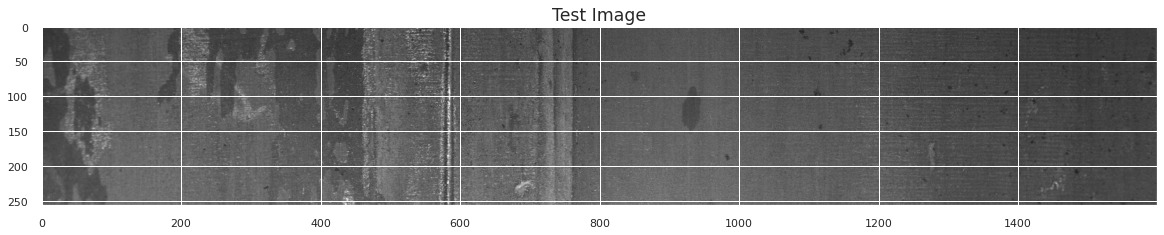

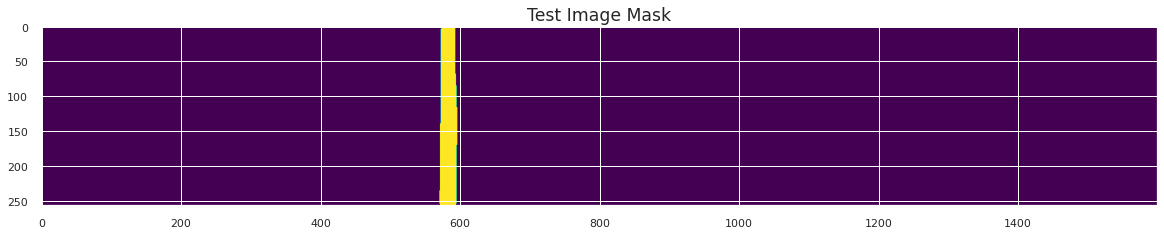

In [ ]:
# Visualizing a test defect image and its Mask

Show_Test_Images(test_data, 0)

Image id :  002451917.jpg


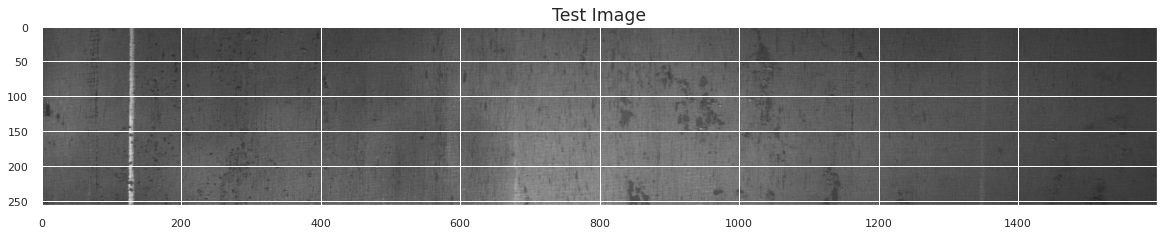

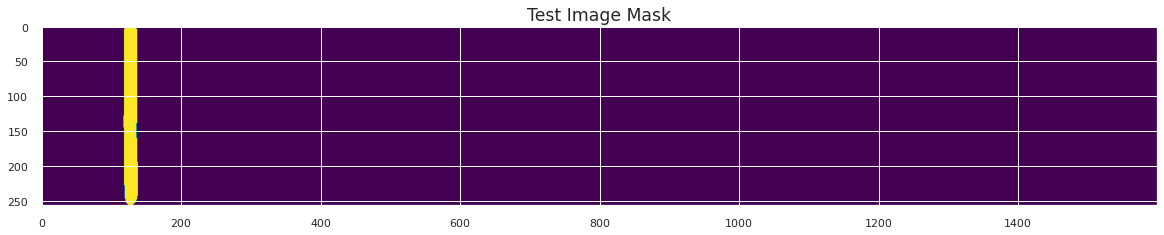

In [ ]:
# Visualizing a test defect image and its Mask

Show_Test_Images(test_data, 2)

Image id :  676518b85.jpg


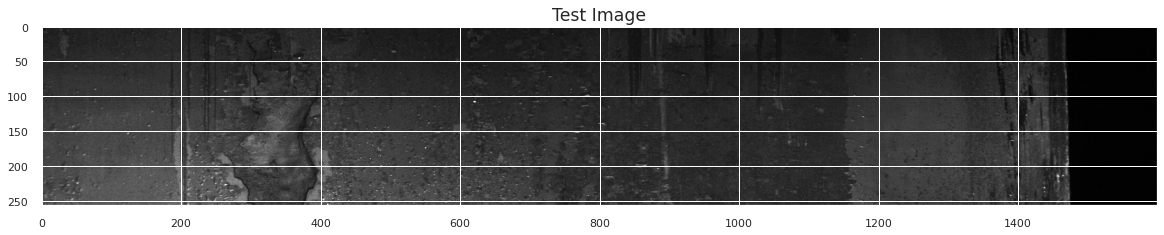

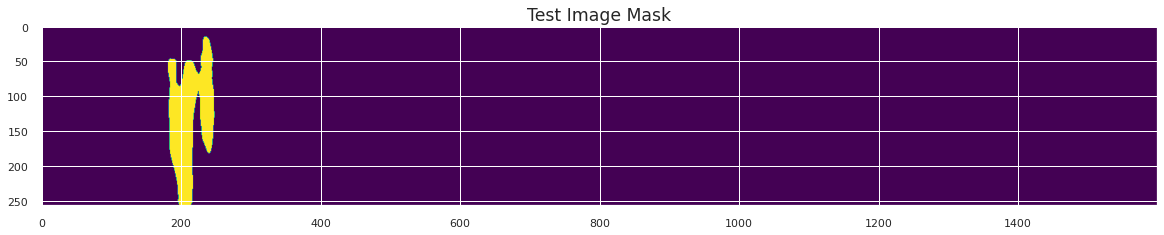

In [ ]:
# Visualizing a test defect image and its Mask

test_idx = random.choice(test_data.index)
Show_Test_Images(test_data, test_idx)

Image id :  d612303c8.jpg


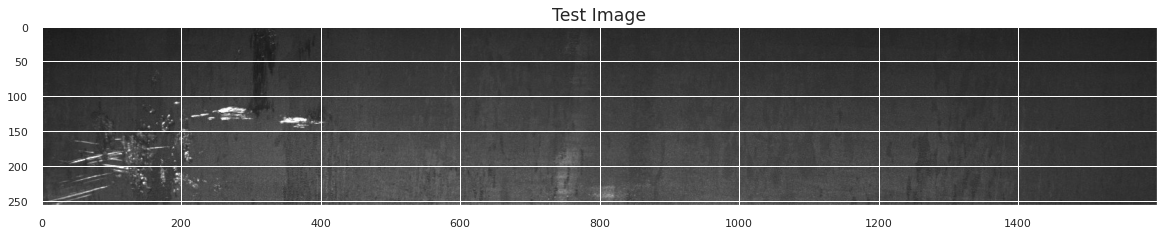

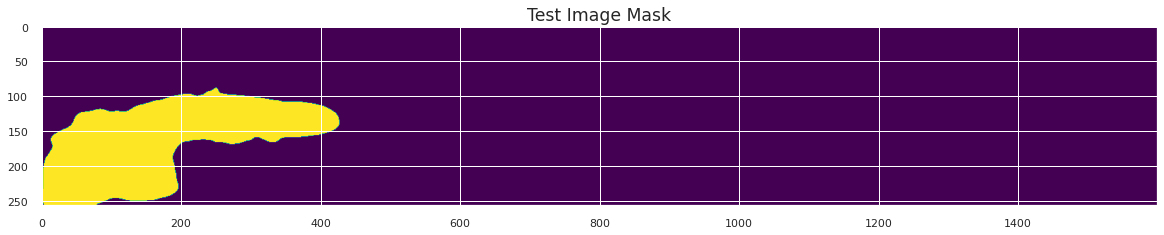

In [ ]:
# Visualizing a test defect image and its Mask

test_idx = random.choice(test_data.index)
Show_Test_Images(test_data, test_idx)

Image id :  8187f1b45.jpg


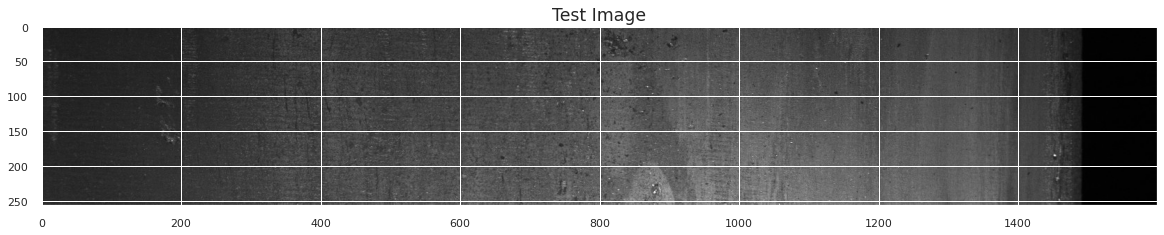

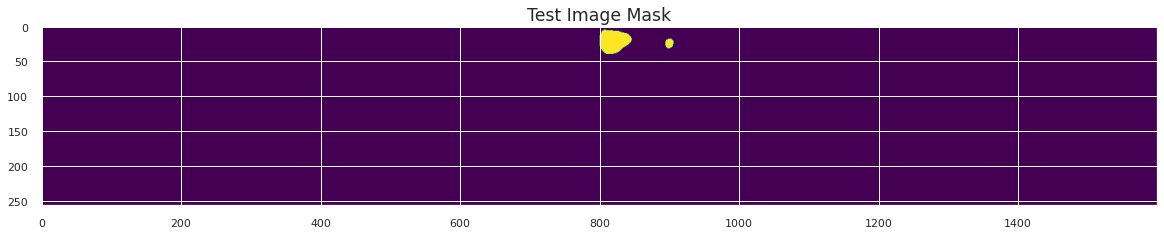

In [ ]:
# Visualizing a test defect image and its Mask

test_idx = random.choice(test_data.index)
Show_Test_Images(test_data, test_idx)

## **5. Conclusion**

As this problem dealt with binary classification, multi label classification and segmentation, the following approach was used to generate the results:
  - First, getting the image from the data pipeline and feeding it into the binary classifier to filter out the defected and undefected images apart
  - Then, filter out the undefected images and proceed with only defected images detected by the binary classifier
  - Then, put the defected images inside the multi label classifier detect the Defect Class 
  - Then, each defect will go to their corresponding individually trained model per defect and to get the mask in the size (256, 800, 1) which will be resized to the original image size of (256, 1600, 1) which can be correctly converted to run length encoding of the mask

**Further scope :**

  - The results are good using the current approches, but there is still some scope to improve the model using more newer SOTA models